### Results visualisation

We visualise results of trained networks on the mr_sag_kr/test* datasets!

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
"""
Declare net here

for example:

net = UNetWCT('./saved_models/ct_unetwct/encoder ct_unetwct',
              './saved_models/ct_unetwct/decoder ct_unetwct',
              # 10, 1, [25, 54, 27, 22, 52, 16, 8 ,4, 36, 7])
              6, 1, [4,7,11,24,25,27])

net.UNet.load_state_dict(
            torch.load(os.path.join('./saved_models/ct_unetwct/ct_unetwct'),
                       map_location=lambda storage, loc: storage))

"""


from models.unet import UNet, UNetDense, UNetWavelet

# net = UNet(1, 1, track_running_stats=True, norm_layer=nn.BatchNorm2d, affine=True)
net = UNet(1, 1)
# net = UNetDense(1, 1, norm_layer=nn.BatchNorm2d, affine=True, track_running_stats=True)
# net = UNetWavelet(1, 1)

# net = UNet(1, 1)
# net = UNet(1, 1, domain_specific=True)
# refine_net = UNet(1, 1, norm_layer=nn.BatchNorm2d, affine=True, track_running_stats=True)

# outputs to test?

# plain_unet_sobel - baseline # 1 0.62 dice
# exp10_unet_sobel_2 - baseline # 2 0.777

# 10 batch size
# best one - mcd_sobel_exp2 # 3 0.832
# alternative - unet_sobel_swd_eadan_in_10_batch_20_epochs, mcd_induced_exp4

net.cuda()
net.load_state_dict(torch.load(os.path.join('./results/unet_sobel_eadan_in/net'), 
                               map_location=lambda storage, loc: storage))

# net.load_state_dict(torch.load(os.path.join('./results/dsbn_final/ds_unet'), map_location=lambda storage, loc: storage))
# net.set_domain(1)


# refine_net.cuda()
# refine_net.load_state_dict(torch.load(os.path.join('./results/unet_shape_model/refiner'), 
#                                map_location=lambda storage, loc: storage))

# net.set_domain(1)

# summary(net, (1, 256, 256))

# pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
# print(pytorch_total_params)

# for n, p in net.named_parameters():
#     print(n, p.numel())

<All keys matched successfully>

In [401]:
# # WCT2 stuff
# from models.wct2 import WCT2Features


# wct2net = WCT2Features([25,54,16,22,61,4,8,27,7,3], 
#                        './wct2_weights/wave_encoder_cat5_l4.pth', 
#                        './wct2_weights/wave_decoder_cat5_l4.pth').cuda()

# wct2net.load_state_dict(torch.load(os.path.join('./results/exp6_wct2_gan_unet_instancenorm/g.pth'), 
#                                    map_location=lambda storage, loc: storage))


# net = UNet(10, 1)
# net.cuda()
# net.load_state_dict(torch.load(os.path.join('./results/exp6_wct2_gan_unet_instancenorm/seg.pth'),
#                                map_location=lambda storage, loc: storage))



In [3]:
# Put dataset here!
from torch.utils.data import DataLoader
from data.dataset import UnpairedDataset
# 21, 22, 15, 23, 16
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)

ct_scans = UnpairedDataset('../', path_a='ct_sag_kr/test', path_b=None)
all_scans = UnpairedDataset('../', path_a='mr_sag_kr/test', path_b=None)
gold_scans = UnpairedDataset('../', path_a='mr_sag_kr/test_gold', path_b=None)
std_scans = UnpairedDataset('../', path_a='mr_sag_kr/test_std', path_b=None)
paired = UnpairedDataset('../', path_a='ct_sag_kr/test', path_b='mr_sag_kr/test_gold')

ct_loader = DataLoader(ct_scans, batch_size=1, shuffle=False, num_workers=5, pin_memory=True)
all_loader = DataLoader(all_scans, batch_size=1, shuffle=True, num_workers=5, pin_memory=True)
gold_loader = DataLoader(gold_scans, batch_size=1, shuffle=False, num_workers=5, pin_memory=True)
std_loader = DataLoader(std_scans, batch_size=1, shuffle=True, num_workers=5, pin_memory=True)
paired_loader = DataLoader(paired, batch_size=1, shuffle=False, num_workers=5, pin_memory=True)

In [5]:
import skimage


def overlay_mask(image, mask, alpha=0.06, clr=[[0,5,0]]):
    # img_color = skimage.color.gray2rgb(image)
    img = skimage.color.label2rgb(mask, image, bg_label=0, alpha=alpha, image_alpha=0.8, colors=clr)
    return img # skimage.exposure.equalize_hist(img)

222 0 0.7143902778625488 0.097686767578125


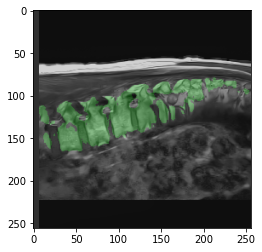

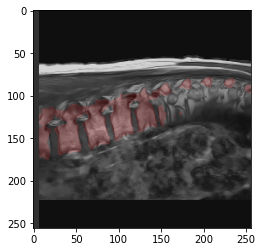

240 1 0.8002085089683533 0.1249542236328125


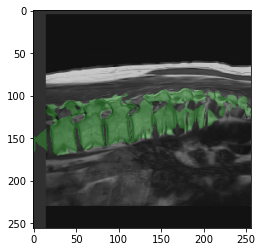

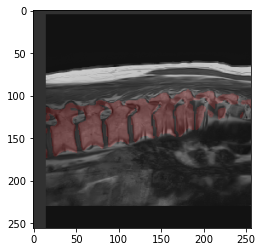

276 2 0.7978020906448364 0.136260986328125


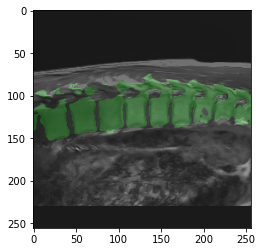

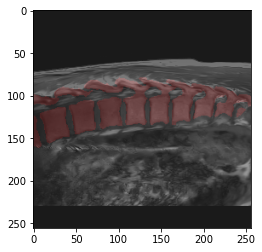

280 3 0.8328896760940552 0.15679931640625


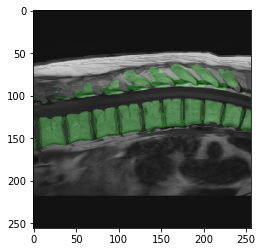

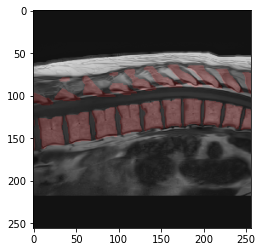

mean dice  0.7863226383924484
mean h95  8.585633911516865
mean recall  0.25607511045655373


In [7]:
# Visualise results here!
import matplotlib.pyplot as plt
from utils.metrics import compute_dice_metric
from PIL import Image
from utils.fda import FDA_source_to_target


# metrics
# recall and F1
from sklearn.metrics import recall_score, f1_score
from scipy.spatial.distance import directed_hausdorff


def threshold_prediction(img, threshold=0.8):
    return (img > threshold).float()


def nm(x):
    return (x - x.min()) / (x.max() - x.min())


def show_image(img, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()
    
    
def plot_histo(arr):
    non_zeros = np.array([el for el in arr.ravel() if el != 0])
#     print(len(non_zeros))
    plt.hist(non_zeros)
    plt.show()

    
loader = gold_loader
dices = []
h95s = []
recalls = []

# i = 8 or 32 for visuals - 8 for mr and 32 for CT
# i = 54 for CT

# i = 4 for CT with few vertebrae pixels

count = 0

for i, data in enumerate(loader):
    # test 250 images
        
    image = data['A'][0].cuda()
    mask = data['A'][1].cuda()
    edge = data['A'][2].cuda()
    # corr = data['A'][3].cuda()
    mask_np = mask.squeeze().cpu().numpy()
    ratio = (mask_np.sum() / np.prod(mask_np.shape))
    
# MR slices = [280, 276, 272, 251, 240, 222]
    slices = [222, 240, 276, 280]
    if i not in slices:
        continue
    
    # for wct2
#     with torch.no_grad():
#         image = torch.cat([image,image,image], dim=1)
#         image = wct2net(image)

#     if ratio < 0.01:
#         continue
    
#     image_target = data['A'][0].cuda()
#     image = FDA_source_to_target(image, image_target, 0.02).cuda()
    
    if torch.max(mask) == 0:
        continue

    with torch.no_grad():
        pred = net(edge)
        
#         pred_nums = pred.squeeze().cpu().numpy()
#         plot_histo(pred_nums)

#         print((pred > 0.3).shape)
#         pred = torch.round(net(edge))
        factor = 0.5
        pred = threshold_prediction(pred, 0.5)
#         pred_ref = refine_net(pred)
#         pred_ref = threshold_prediction(pred_ref, 0.5)
#         pred = threshold_prediction(factor * pred + (1 - factor) * pred_ref, 0.5)
        dice = compute_dice_metric(pred, mask).item()
    
    image_np = image.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()
    
    print(i, count, dice, ratio)
    pred_map = overlay_mask(image_np, pred_np, 0.04)
    gt_map = overlay_mask(image_np, mask_np, 0.03, [[5,0,0]])
    show_image(pred_map)    
    show_image(gt_map)
#     show_image(mask_np)
#     show_image(pred_np)
#     show_image(corr.squeeze().cpu().numpy())
    dices.append(dice)

    # compute robust hausdorff (0.95)
    h95 = 0.95 * max(directed_hausdorff(mask_np, pred_np)[0], directed_hausdorff(pred_np, mask_np)[0])

    # print(f1, recall, h95)
    h95s.append(h95)
    
    rec = recall_score(mask_np, pred_np, labels=[0, 1], average='micro')
    recalls.append(rec)
    
    plt.imsave('./thesis_results/best_mr_{}.png'.format(i), pred_map)
    plt.imsave('./thesis_results/best_mr_gt_{}.png'.format(i), gt_map)
    
    # plt.imsave('./thesis_results/mr_bad_gt.png', gt_map)
    # plt.imsave('./isbi_results/ct_seg.png', pred_np, cmap='gray')
    # save the image here!
    
    count += 1
    # break

print('mean dice ', np.mean(dices))
print('mean h95 ', np.mean(h95s))
print('mean recall ', np.mean(recalls))

# 0.160, 0.16, 0.16

In [279]:
# mr - mean dice  0.5505742187184902
# ct - 

SyntaxError: invalid syntax (<ipython-input-279-cefe234e54b7>, line 1)

In [23]:
# 3 vals for swd eadanin
# 0.62, 0.626, 0.640

# wct handpicked
mean dice  0.8464936307103998
mean h95  3.5863614651415543
mean recall  0.4260145276266741

mean dice  0.7905552176051882
mean h95  4.035267249723969
mean recall  0.40235083700715685

mean dice  0.6544912152716683
mean h95  8.827009998470999
mean recall  0.14791761912555945

[]

In [119]:
np.mean([0.62, 0.626, 0.640])

0.6286666666666667

In [ ]:
# 746 CT slice, 287 MR slice

# Thesis results
# 01 - CT - 0.759, MR - 0.156
# 02 - CT - 0.767, MR - 0.150
# 03 - CT - 0.769, MR - 0.128
# 04 - CT - 0.650, MR - 0.230
# 05 - CT - 0.733, MR - 0.163

# 06 - CT - 0.747, MR - 0.151
# 07 - CT - 0.724, MR - 0.109
# 08 - CT - 0.838, MR - 0.214


In [ ]:
# ISBI results
# put results here dice, hausdorff and respective std! - put results in array!

# plain_unet_final - plain UNet
# dices = [0.10037092795650356, 0.10177221070904102, 0.09924121791935495, 0.10009683817874111, 0.09914480147642214]
# hausdorf = [10.145244400423616, 10.140494663252197, 10.16344320388977, 10.131213088551885, 10.195365737283321]

# plain_mcd_final - plain mcd
# dices = [0.137577205368192, 0.1383025814779305, 0.13659828514812897, 0.13542503835725136, 0.1377713427699978]
# hausdorf = [10.366328330703178, 10.414881056077668, 10.410492704361262, 10.424023283755947, 10.416536909222229]

# plain_sliced_mcd_final - mcd with SWD
# dices = [0.14690331194415326, 0.14723133917977818, 0.14691833064815335, 0.14658343207858043, 0.14594228413768492]
# hausdorf = [10.171175449513028, 10.150920429196855, 10.169769583407106, 10.162861798201325, 10.188987370737019]

# final_fda_03 - FDA with 0.02 amplitude scaling - do this one later!
# dices = [0.1264268740741407, 0.1264395040361679, 0.12500124313956734, 0.12558176408006913, 0.12395977855262859]
# hausdorf = [10.319820976996066, 10.305481187686135, 10.347600221595291, 10.364132762083221, 10.37480992571693]

# plain_unet_sobel - baseline # 1 0.62 dice
# dices = [0.4808360231350143, 0.48269747731932605, 0.4767395307521421, 0.4770458111042283, 0.4756741902802095]
# hausdorf = [9.4269376811709, 9.453275622137463, 9.459829273045996, 9.474492785367403, 9.51973747827922]

# unet_sobel + adabn
# dices = [0.5489367615297971, 0.5533777223343394, 0.5514127915183387, 0.5461562726780238, 0.547703714811232]
# hausdorf = [9.120269902294087, 9.122406943913955, 9.147277630846691, 9.164941209212648, 9.165092111395293]


# exp10_unet_sobel_2 - baseline + normalization # 2 0.777
# dices = [0.55369083314904, 0.558332289645144, 0.554021822318316, 0.5518667476837972, 0.5543983771461505]
# hausdorf = [9.071535876726662,  9.031207651446062, 9.085507623194724, 9.079528838247237, 9.091025266777653]

# SWD + sobel
# dices = [0.5798531098076072, 0.5763231502081531, 0.5772444732873089, 0.5782180370770366, 0.5792168695108587]
# hausdorf = [9.386991331475674, 9.387046500364585, 9.422780042628858, 9.404803264137765, 9.435728359258675]

# mcd_sobel_exp2 - SPINAL (best network) # 3 0.832
# dices = [0.6468020982416978, 0.646971153785508, 0.6462393136197827, 0.6457881888307898, 0.6476100527373443]
# hausdorf = [8.909019706080347, 8.90599351357345, 8.937906509219324, 8.935234939831625, 8.941844710098946]


In [26]:
# dont put std as most std are lower than the given precisions
dices = [0.5489367615297971, 0.5533777223343394, 0.5514127915183387, 0.5461562726780238, 0.547703714811232]
hausdorf = [9.120269902294087, 9.122406943913955, 9.147277630846691, 9.164941209212648, 9.165092111395293]

print('mean dice ', np.mean(dices))
print('std dice ', np.std(dices))

print('mean hdf ', np.mean(hausdorf))
print('std hdf ', np.std(hausdorf))

mean dice  0.5495174525743461
std dice  0.002585280232026687
mean hdf  9.143997559532533
std hdf  0.019613933052064627


In [43]:
# 0.23376623376623376 0.13636363636363635 8.911789943664516

def compute_f1(p, g):
    p = p.ravel()
    g = g.ravel()    
    pass

# compute recall on foreground
def compute_recall(p, g):
    p = p.ravel()
    g = g.ravel()
    print(p.shape, g.shape)
    fn = np.logical_and(p==0,g==1).astype(np.uint8)
    print(fn)
    return p.sum() / (p.sum() + fn.sum())


# recall - 3 / 3 + 1
# TP - 3
# FN - 1

p = np.array([0, 1, 1])
g = np.array([1, 1, 1])

print(np.logical_and(p==0,g==1).astype(np.uint8))

res1 = compute_recall(p, g)
res2 = recall_score(p, g, labels=[0, 1], average='micro')
print(res1, res2)

[1 0 0]
(3,) (3,)
[1 0 0]
0.6666666666666666 0.6666666666666666


In [47]:
(torch.Tensor([1,2])>1.5).float() * 1

tensor([0., 1.])